# Predictive Modeling: California Housing

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as skl
import seaborn as sns
import keras
import keras.utils
from keras import utils as np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn import datasets, neighbors
import sklearn.datasets
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import PredictionErrorDisplay
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
import random


sns.set_theme()
plt.style.use('ggplot')
random.seed(42)
np.random.seed(42)

The target variable in this regression problem is the median house value (MedHouseVal) for California districts, expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bureau publishes sample data (a block group typically has a population
of 600 to 3,000 people).

A household is a group of people residing within a home. Since the average
number of rooms and bedrooms in this dataset are provided per household, these
columns may take surprisingly large values for block groups with few households
and many empty houses, such as vacation resorts.

In [ ]:
housing_data = fetch_california_housing(as_frame=True)
housing_data.frame

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


To start, we'll perform some minor descriptive analysis which will aid us in our predictive analysis. Using the housing_data dataframe (`housing_data.frame`), I will plot marginal distributions of each variable in the form of histograms or density plots.  For each variable, I will identify and state any distribution issues that might cause problems in analysis, including (but not limited to): skewed distributions, bimodal distributions, very frequent values, presence of outliers, etc.

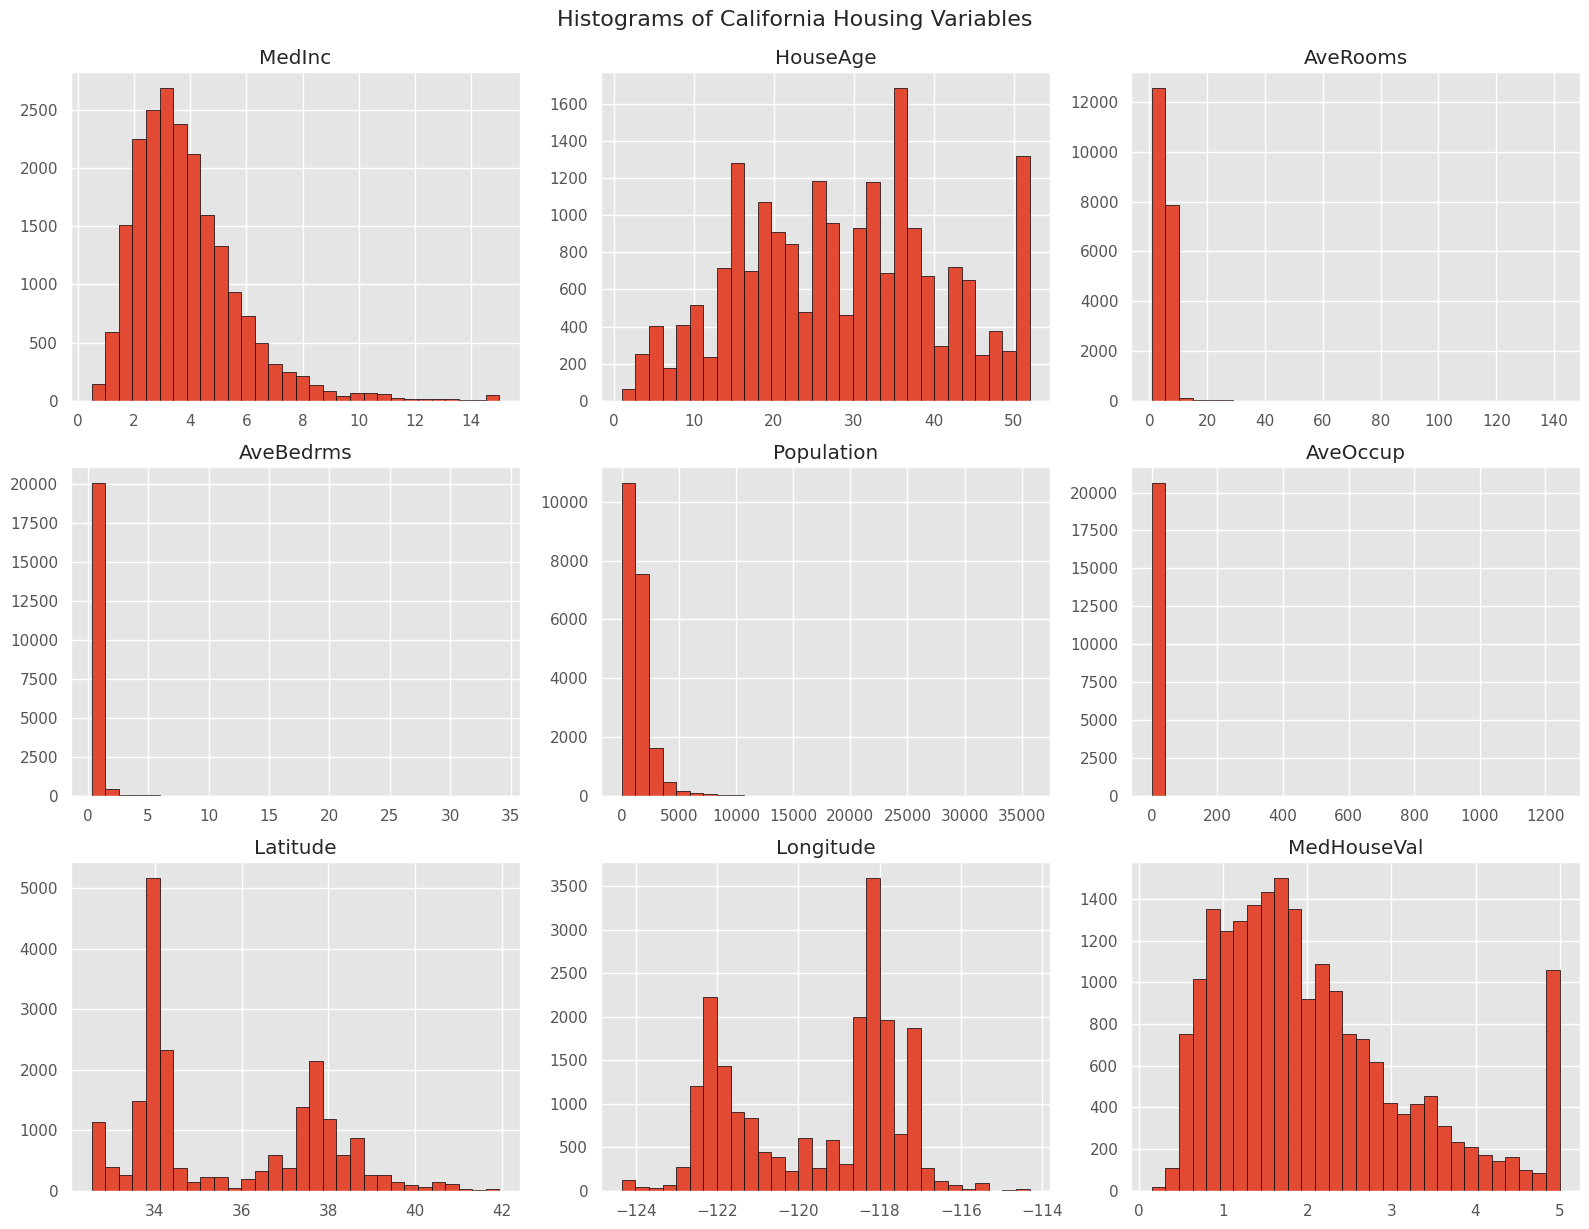

In [ ]:
housing_data = fetch_california_housing(as_frame=True)
df = housing_data.frame

df.hist(bins=30, figsize=(16, 12), edgecolor='black')
plt.tight_layout()
plt.suptitle("Histograms of California Housing Variables", fontsize=16, y=1.02)
plt.show()


Median Income: Right-skewed distribution with a long tail of higher incomes. This skewness could bias models toward underestimating the influence of income on housing values. In linear regression, the model fits a single line across the entire range. The few high-income cases don’t have enough weight to strongly influence the slope, so the model mostly “learns” from the more frequent low-to-mid income range. This leads to a flatter slope than needed, causing underestimation at the high end.

House Age: Distributed evenly but has some outliers. Outliers might influence the model disproportionately, leading to higher variance or misleading trends. Here, outliers can disproportionately affect the position of the regression line. This can lead to either inflating or flattening the true effect of age, especially if outliers don't follow the general trend.

Average Room/Bedrooms: Heavily skewed and has outliers. Models might overfit and skewness could influence feature importance. The presence of a few extreme values increases the range the model must account for. To minimize error across this wide range, the model tends to flatten the relationship, essentially choosing a slope that fits the extremes poorly but reduces total error, at the cost of being less accurate for the bulk of the data.

Average Occupation: Heavily skewed and has outliers. The model might overstate the impact of crowding or produce noisy predictions. Some regions in the dataset exhibit significantly different patterns, which the model struggles to account for. This leads to the model overfitting to these unusual cases, ultimately reducing its overall performance on more "typical" data points.

Population: Right-skewed distribution. Models might be influenced heavily by large populations unless normalized; large population centers might dominate the learning process. Large populations create variance in error, which increases with the predictor. The model might either overfit the large tracts or ignore them altogether, depending on their influence, both of which are problematic for generalization.

Latitude/Longtitude: Bimodal Distribution with outliers. Bimodality could indicate that different subregions behave differently. Bimodal distributions violate the assumption that data is sampled from a single, homogeneous distribution. The model tries to find one trend line, but really there are different regions that show distinct patterns in housing prices. This can lead to misleading coefficients or averaged-out predictions that don’t fit any group well.

Median House Value: Slightly Right-skewed distribution. Models could underpredict high-value homes and regression performance may suffer. Skew in the dependent variable means the residuals won’t center cleanly around zero.

Next, using the `Pandas.DataFrame.corr` function, I will produce a correlation matrix of the variables in our housing dataset. Given the correlation values, I will find good predictor variables of our target variable MedHouseVal in a simple linear regression.

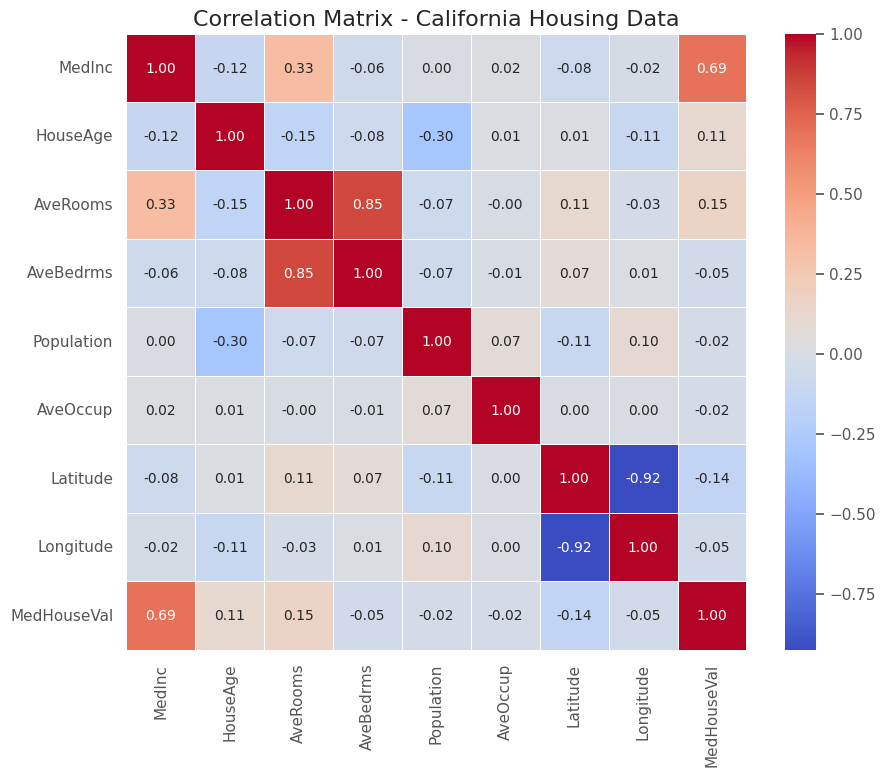

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix - California Housing Data", fontsize=16)
plt.show()


Given the correlation values, the variables that are most likely to predict MedHouseVal in a simple linear regression are variables that have a strong positive correlation. Specifically, MedInc, HouseAge, and AveRooms all have positive correlation with MedHouseValue. 


I will create a scatterplot matrix using the available numerical features from the California Housing dataset to better identify any pairs of features that appear to have strong linear or non-linear relationships with each other. Then, using the results, I will compare my observations to the correlation matrix computed earlier to see if any feature pairs  show weak correlation coefficients but display visible structure or dependency in the scatterplots (e.g., non-linear relationships).


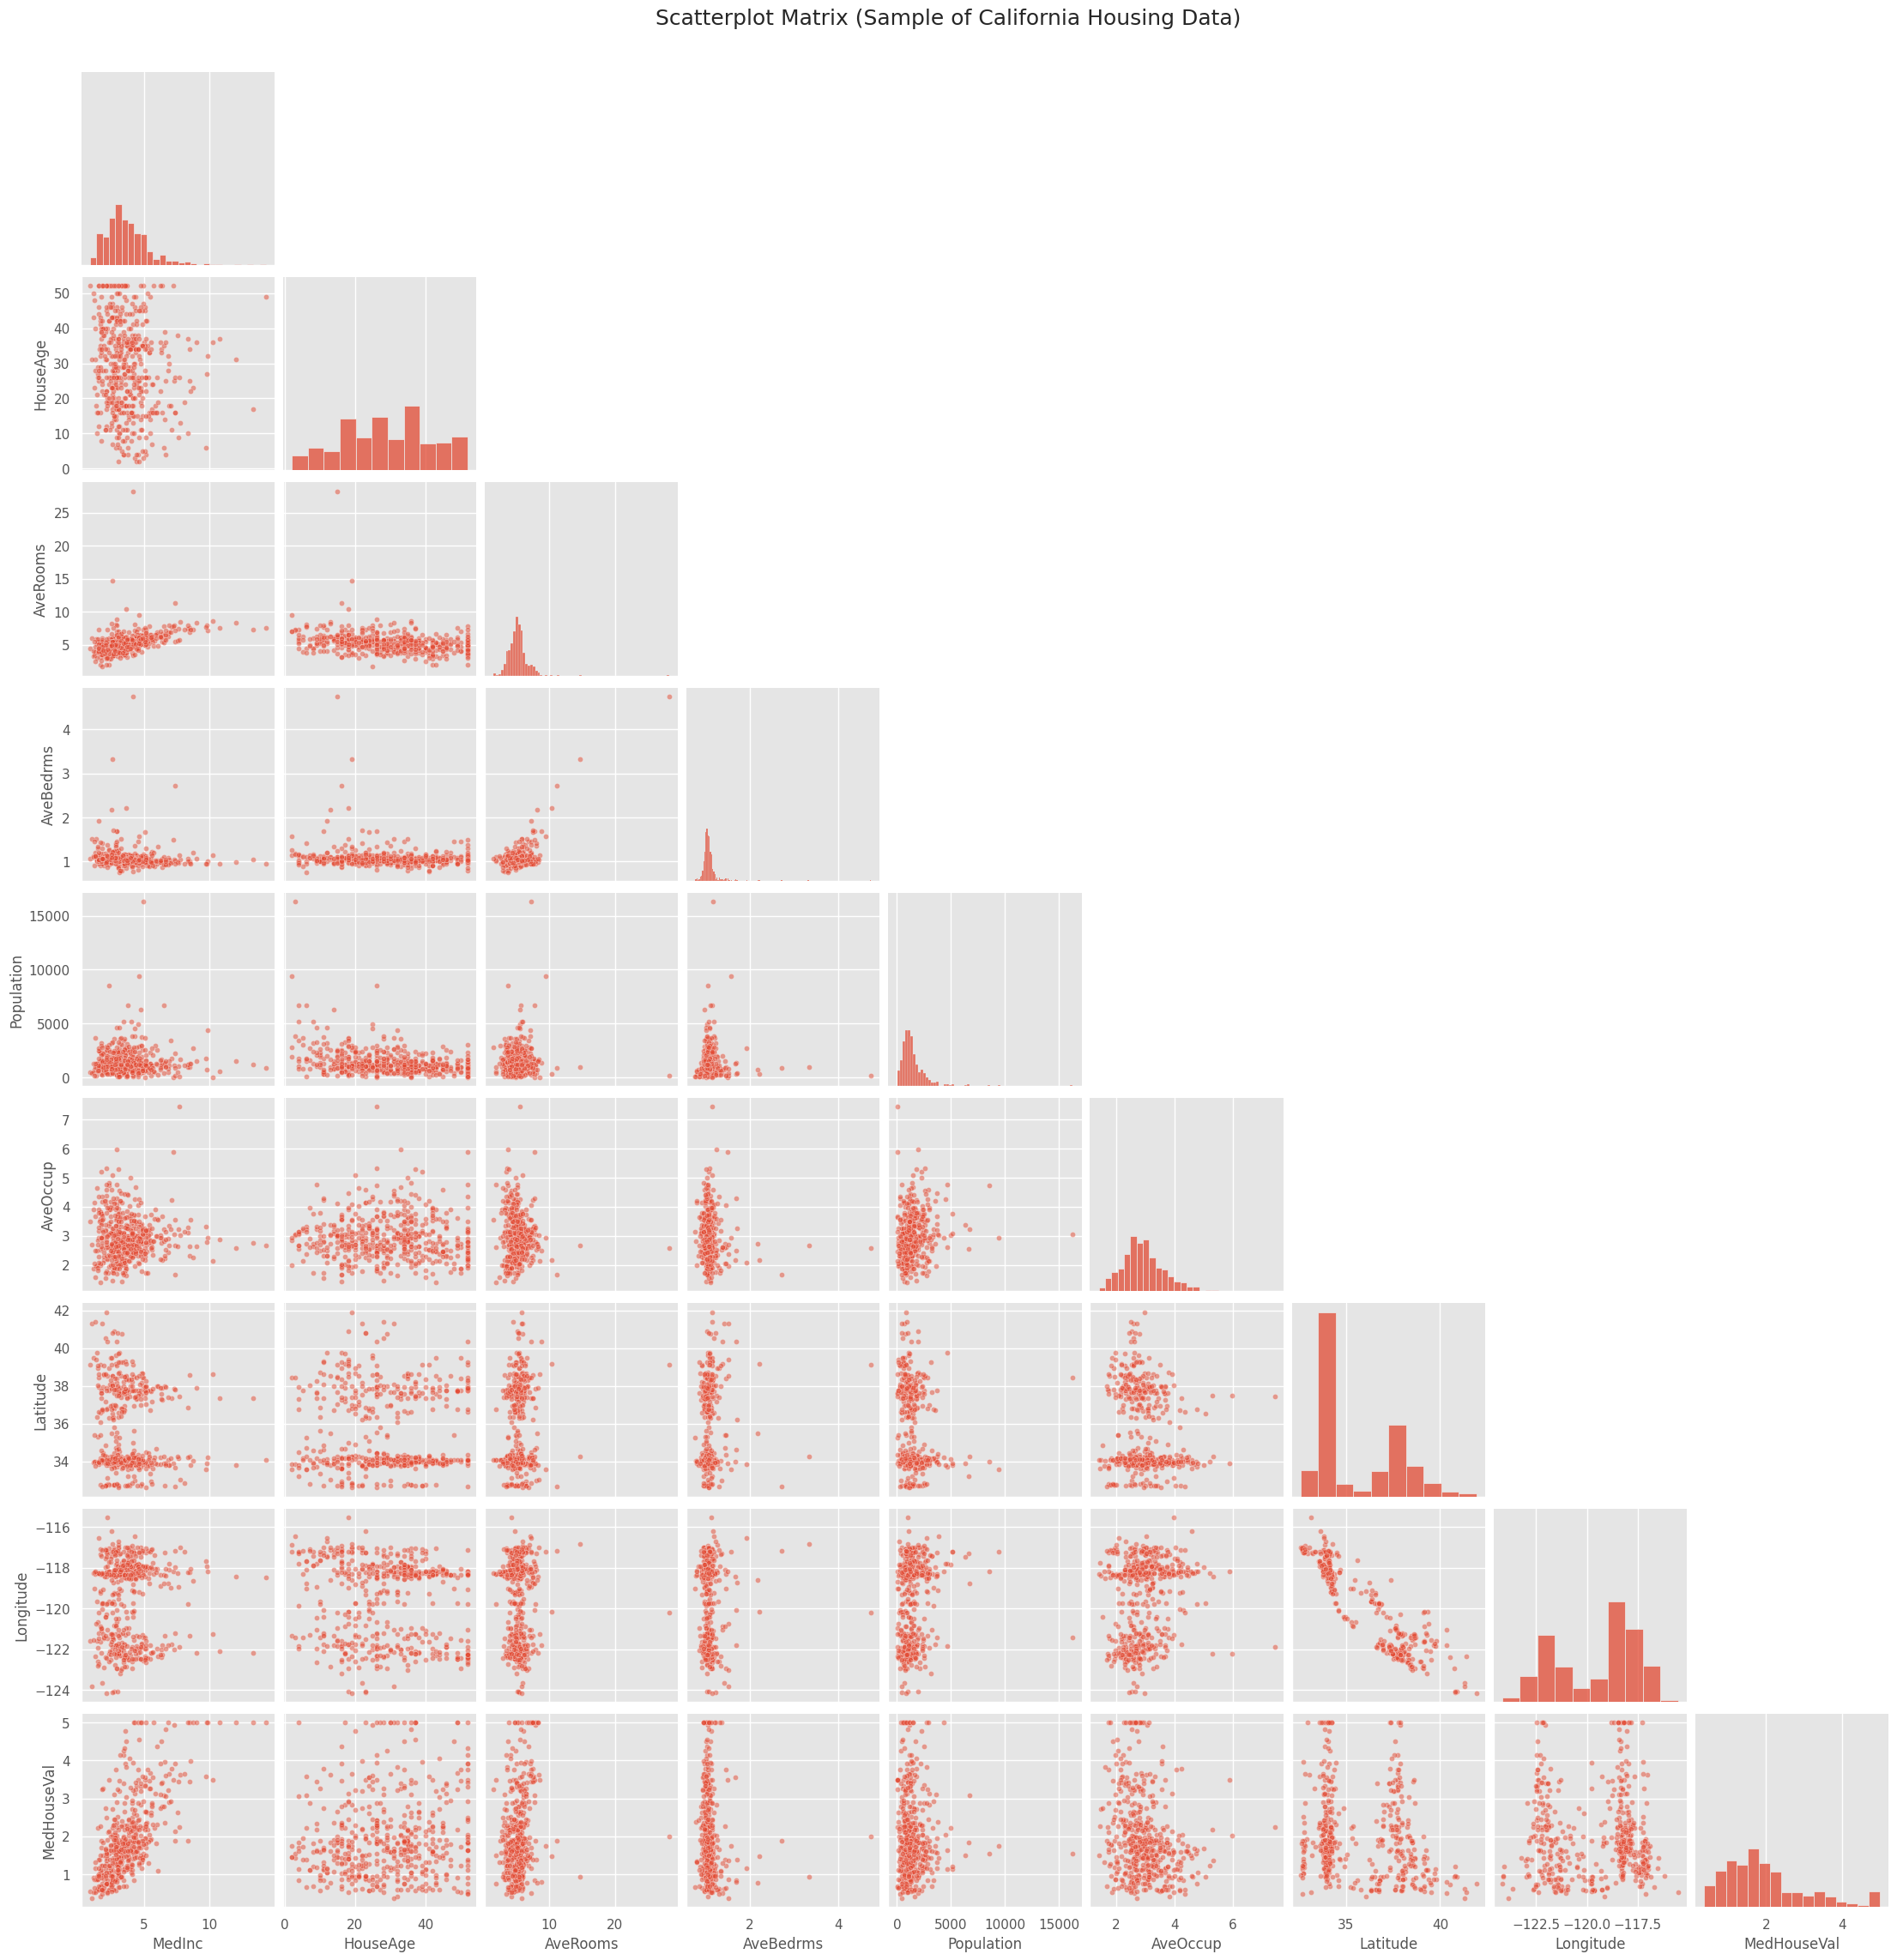

In [ ]:
sns.pairplot(df.sample(500), corner=True, plot_kws={'alpha': 0.5, 's': 20})
plt.suptitle("Scatterplot Matrix (Sample of California Housing Data)", y=1.02, fontsize=18)
plt.show()



Strong Linear Relationships:

AveRooms and AveBedrooms (0.85)

Latitude and Longitude (-0.92)

MedInc and MedHouseVal(0.69)

Non-Linear Relationships:

Population and Housing Variables

Latitude/Longitude and MedHouseVal

Average Occupation and MedHouseVal

The strong correlations are displayed in both the correlation matrix and the scatterplot matrix, such as the relationship between AveRooms and AveBedrooms (0.85), the inverse relationship between Latitude and Longitude (-0.92), and the positive correlation between median income and house values (0.69).
However, many important patterns appear in the scatterplots that aren't shown well by the correlation coefficients. Housing values show geographical clustering (especially around the coast of California) that isn't reflected in their weak correlation numbers with Latitude (-0.14) and Longitude (-0.05). Population-related scatterplots show L-shaped patterns indicating boundary effects where high-value housing rarely occurs in densely populated areas, despite the near-zero correlation coefficient (-0.02). House age also shows clustered patterns with several variables despite little to no linear correlations.

Given our analysis earlier, longitude and latitude variables would be good variables to analyze as well, and how they relate to other variables.

The first plot is a scatterplot with the `Longitude` variable on the x-axis and the `Latitude` variable on the y-axis. The `MedHouseVal` variable corresponds to the size and hue of each data example. The plot has an appropriate title, axes labels, and legend.

The second plot should be a scatterplot with the `Longitude` variable on the x-axis and the `Latitude` variable on the y-axis. Then we want the `MedInc` variable to correspond to the size and hue of each data example.

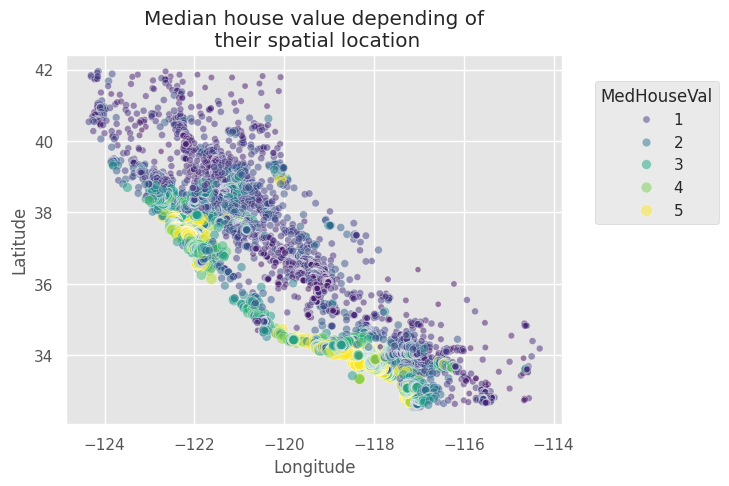

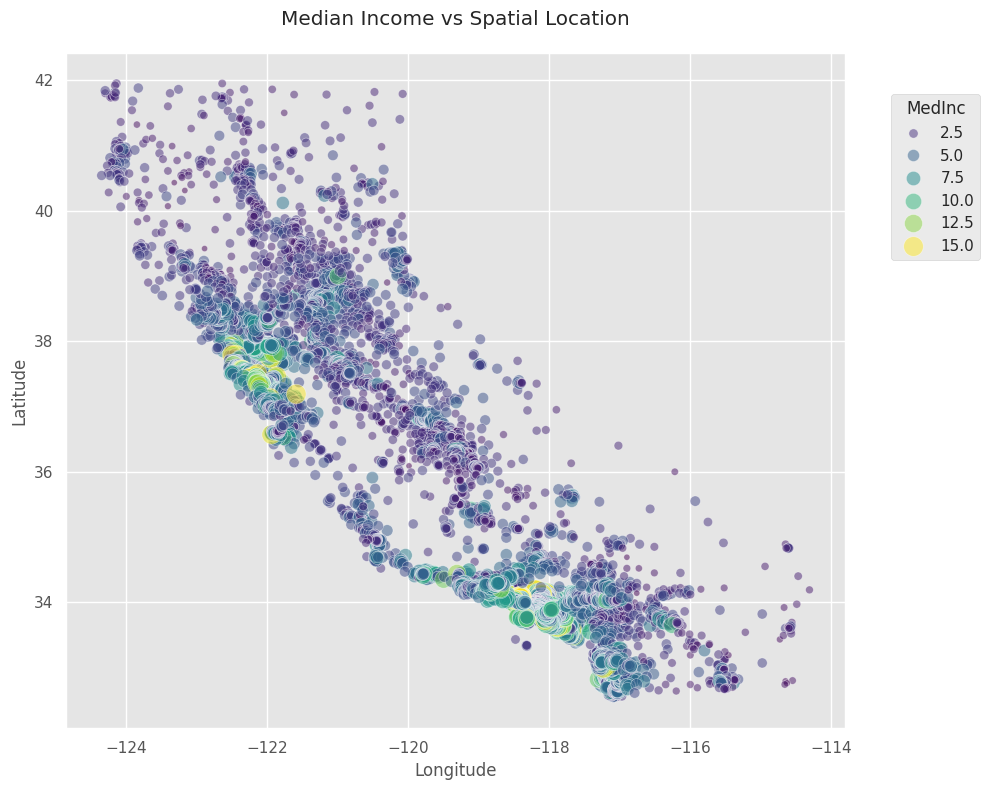

In [ ]:
plt.figure()
sns.scatterplot(
    data=housing_data.frame,
    x="Longitude",
    y="Latitude",
    size="MedHouseVal",
    hue="MedHouseVal",
    palette="viridis",
    alpha=0.5,
)
plt.legend(title="MedHouseVal", bbox_to_anchor=(1.05, 0.95), loc="upper left")
_ = plt.title("Median house value depending of\n their spatial location")

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=housing_data.frame,
    x="Longitude",
    y="Latitude",
    size="MedInc",
    hue="MedInc",
    palette="viridis",
    alpha=0.5,
    sizes=(20, 200)
)

plt.title("Median Income vs Spatial Location", pad=20)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="MedInc", bbox_to_anchor=(1.05, 0.95), loc="upper left")

plt.tight_layout()
plt.show()




Looking at the scatter plots, an interesting thing to note is that the plot geographically resembles a map of California when plotted.


Also, the median income and median house value vary by geographic location. Higher values for both are clustered along specific regions, particularly along the coast and in the southern part of the state. Based on my analysis from earlier parts, other variables that appear to be strong predictors of median house value are Median House Income, Average Rooms, and House Age.

Given our analysis above, we've identified several predictor variables which seem relevant to predicting the `MedHouseVal` variable. Now, let's develop a ridge regression model using cross validation. We'll use sklearn's `cross_validate` function to train our model. We recorded and presented the R-squared value statistics and the models' coefficients in a boxplot. 

R2 score: 0.553 ± 0.062
Average CV coefficients: 
MedInc        0.434099
HouseAge      0.009333
AveRooms     -0.103325
AveBedrms     0.636810
Population   -0.000004
AveOccup     -0.004593
Latitude     -0.422414
Longitude    -0.435741
dtype: float64


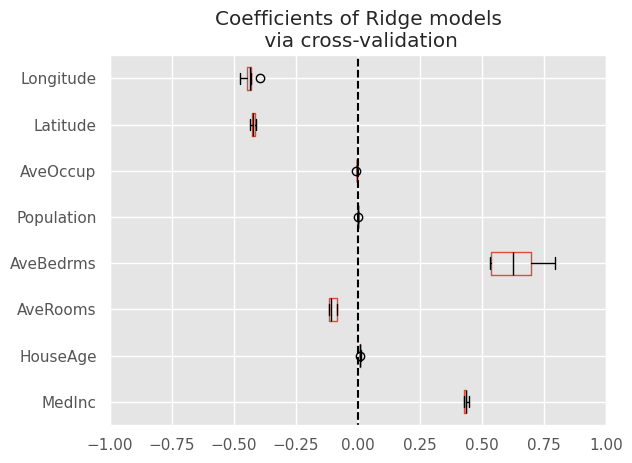

In [ ]:
alphas = np.logspace(-3, 1, num=30)
model = make_pipeline(RidgeCV(alphas=alphas))
cv_results = cross_validate(
    model,
    housing_data.data,
    housing_data.target,
    return_estimator=True
)

score = cv_results["test_score"]
print(f"R2 score: {score.mean():.3f} ± {score.std():.3f}")

coefs = pd.DataFrame(
    [est[-1].coef_ for est in cv_results["estimator"]],
    columns=housing_data.feature_names,
)
print(f"Average CV coefficients: \n{coefs.mean()}")

color = {"whiskers": "black", "medians": "black", "caps": "black"}
coefs.plot.box(vert=False, color=color)
plt.axvline(x=0, ymin=-1, ymax=1, color="black", linestyle="--")
plt.xlim([-1,1])
_ = plt.title("Coefficients of Ridge models\n via cross-validation")

One variable, in particular, Average Bedrooms, has a positive coefficient with a high magnitude. This represents a strong direct relationship between Average Bedrooms and Median House Value. We know that this coefficient is actually showing a real relationship instead of appearing by random chance because the boxplot shows consistently positive coefficients for Average Bedrooms across all cross-validation folds. If it were random, we'd expect the coefficients to vary widely in sign and magnitude across folds. In other words, the boxplot for Average Bedrooms has a consistent sign and minor spread (positive and within the 0.55-0.80 range). Additionally, ridge regression shrinks less important coefficients toward zero. So, if a variable like Average Bedrooms still ends up with a strong positive coefficient, it's because the model needs it to minimize prediction error.

Now we're going to repeat our predictive analysis, but this time we'll standardize our predictor variables before fitting a ridge regression. We standardize our X data by using sklearn's `StandardScaler` function.

R2 score: 0.553 ± 0.062
Average CV coefficients: 
MedInc        0.824931
HouseAge      0.117995
AveRooms     -0.255109
AveBedrms     0.295928
Population   -0.004188
AveOccup     -0.041022
Latitude     -0.885716
Longitude    -0.856397
dtype: float64


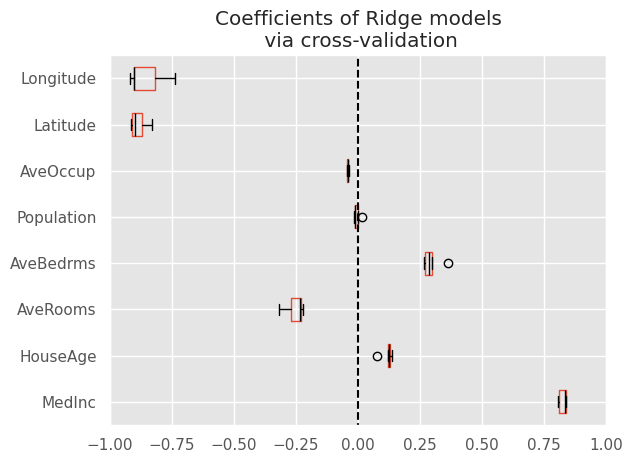

In [ ]:
model1 = make_pipeline(StandardScaler(),
                       RidgeCV(alphas = np.logspace(-3, 1, num=30))
                       )


cv_results1 = cross_validate(
    model1,
    housing_data.data,
    housing_data.target,
    return_estimator=True
)

score1 = cv_results1["test_score"]
print(f"R2 score: {score1.mean():.3f} ± {score1.std():.3f}")

coefs1 = pd.DataFrame(
    [est[-1].coef_ for est in cv_results1["estimator"]],
    columns=housing_data.feature_names,
)
print(f"Average CV coefficients: \n{coefs1.mean()}")

color = {"whiskers": "black", "medians": "black", "caps": "black"}
coefs1.plot.box(vert=False, color=color)
plt.axvline(x=0, ymin=-1, ymax=1, color="black", linestyle="--")
plt.xlim([-1,1])
_ = plt.title("Coefficients of Ridge models\n via cross-validation")

Here, we notice the R2 scores from the last plot and this plot are the same.

A small coefficient magnitude in this model means that after standardizing, changing the value of that variable has little effect on predicted house value. This could be because the variable has weak or no correlation with the target and/or the model decided that it was not worth keeping (through regularization).

On the other hand, a high coefficient magnitude means the model gives a lot of weight to that variable in predicting housing prices and are likely to have strong relationships with MedHouseVal.

Now using the earlier analysis, I will drop (apparently) unimportant variables, and re-estimate parameters of a linear regression model with a smaller number of variables.

In [ ]:
important_vars = [v for v in housing_data.feature_names if v not in coefs1.columns[abs(coefs1.mean()) < 0.1]]

print(f"Dropping variables: {list(coefs1.columns[abs(coefs1.mean()) < 0.1])}")
print(f"Keeping variables: {important_vars}")

X_reduced = housing_data.data[important_vars]

reduced_model = make_pipeline(
    StandardScaler(),
    RidgeCV(alphas=alphas)
)

cv_results_reduced = cross_validate(
    reduced_model,
    X_reduced,
    housing_data.target,
    return_estimator=True
)

reduced_score = cv_results_reduced["test_score"]
print(f"Reduced model R2: {reduced_score.mean():.3f} ± {reduced_score.std():.3f}")

reduced_coefs = pd.DataFrame(
    [est[-1].coef_ for est in cv_results_reduced["estimator"]],
    columns=important_vars,
)
print(f"Reduced model coefficients:\n{reduced_coefs.mean()}")


Dropping variables: ['Population', 'AveOccup']
Keeping variables: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Latitude', 'Longitude']
Reduced model R2: 0.555 ± 0.065
Reduced model coefficients:
MedInc       0.823074
HouseAge     0.118359
AveRooms    -0.252385
AveBedrms    0.294475
Latitude    -0.889460
Longitude   -0.860476
dtype: float64



For Ridge Regression without Standardization, the pros are that this approach preserves interpretability and allows a person to see the raw data and how different variables interact with each other without any alteration. It gives a direct sense of how variables in their natural scale relate to house value. However, the cons are that it's harder to compare the relative importance of variables, since they’re on different scales. This can lead to misinterpretation — people might think certain variables are important (or unimportant) just because their raw coefficients are large (or small), even if those differences are only due to the variable's units or scale. In other words: non-standardized coefficients can be misleading, which could result in focusing on variables that don’t actually influence the outcome much.

For Ridge Regression with Standardization, the pros are that standardization puts all variables on the same scale, making the regularization in ridge regression more effective and the coefficient magnitudes directly comparable. This helps in identifying predictors that are actually influential. On the contrary, the cons are that after standardization, the model coefficients lose their real-world units. This means it can be harder to interpret the results directly, since the variables have been scaled and don't reflect their original units.